In [1]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib import pyplot
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential, load_model, Model
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras.utils import np_utils
from numpy.random import RandomState
np.random.seed(0)
import sys
import random
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [2]:
import os
import glob
import cv2
import math
import datetime
from PIL import Image
from io import BytesIO
import pandas as pd
from matplotlib import pylab as plt
use_cache = 1

In [3]:
def extract_features(img_rows, img_cols):
    conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (img_rows, img_cols, 3))
    print(conv_base)
    return conv_base
    

In [4]:
img_rows = 150
img_cols = 150
base_model = extract_features(img_rows, img_cols)
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [5]:
top_model = Sequential()
#model.add(vgg16)
#model.add(Flatten())
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(4096, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(4096, activation='relu'))
top_model.add(Dropout(0.5))

top_model.add(Dense(10, activation='softmax'))

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [6]:
TRAIN_DIR = "D:/ml/kaggle/State Farm Distracted Driver Detection/all/imgs/train/"
TEST_DIR = "D:/ml/kaggle/State Farm Distracted Driver Detection/all/imgs/test/"

In [7]:
def load_train(img_rows, img_cols, color_type=1):
    X_train = []
    y_train = []
    driver_id = []

    driver_data = get_driver_data()

    print('Read train images')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join(TRAIN_DIR, 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im_cv2(fl, img_rows, img_cols, color_type)
            X_train.append(img)
            y_train.append(j)
            driver_id.append(driver_data[flbase])

    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return X_train, y_train, driver_id, unique_drivers

In [8]:
def load_test(img_rows, img_cols, color_type=1):
    print('Read test images')
    path = os.path.join(TEST_DIR, '*.jpg')
    files = glob.glob(path)
    X_test = []
    X_test_id = []
    total = 0
    thr = math.floor(len(files)/10)
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(flbase)
        total += 1
        if total%thr == 0:
            print('Read {} images from {}'.format(total, len(files)))

    return X_test, X_test_id

In [9]:
def read_and_normalize_train_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'train_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        train_data, train_target, driver_id, unique_drivers = load_train(img_rows, img_cols, color_type)
        cache_data((train_data, train_target, driver_id, unique_drivers), cache_path)
    else:
        print('Restore train from cache!')
        (train_data, train_target, driver_id, unique_drivers) = restore_data(cache_path)

    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)
    #train_data = train_data.reshape(train_data.shape[0], color_type, img_rows, img_cols)
    train_data = train_data.reshape(train_data.shape[0], img_rows, img_cols, color_type)
    train_target = np_utils.to_categorical(train_target, 10)
    train_data = train_data.astype('float32')
    train_data /= 255
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target, driver_id, unique_drivers

In [10]:
def read_and_normalize_test_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'test_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        test_data, test_id = load_test(img_rows, img_cols, color_type)
        cache_data((test_data, test_id), cache_path)
    else:
        print('Restore test from cache!')
        (test_data, test_id) = restore_data(cache_path)

    test_data = np.array(test_data, dtype=np.uint8)
    #test_data = test_data.reshape(test_data.shape[0], color_type, img_rows, img_cols)
    test_data = test_data.reshape(test_data.shape[0], img_rows, img_cols, color_type)
    test_data = test_data.astype('float32')
    test_data /= 255
    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    return test_data, test_id


In [11]:
def get_driver_data():
    dr = dict()
    path = os.path.join('D:/ml/kaggle/State Farm Distracted Driver Detection', 'all', 'driver_imgs_list.csv')
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
    f.close()
    return dr

In [12]:
def get_im_cv2(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    elif color_type == 3:
        img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (img_cols, img_rows))
    return resized

In [13]:
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')

In [14]:
def show_train_data(train_data, color_type=1):
    plt.figure(figsize=(12,9))
    row_c = 3
    col_c = 4
    k = 0

    for i in range(1, row_c + 1):
        for j in range(1, col_c + 1):
            plt.subplot(row_c,col_c,k+1)
            if color_type == 3:
                rgb = cv2.cvtColor(train_data[k], cv2.COLOR_BGR2RGB)
                plt.imshow(rgb)
            elif color_type == 1:
                plt.imshow(np.squeeze(train_data[k]), plt.cm.gray)
            k+=1

In [15]:
def create_submission(predictions, test_id, info):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('D:/ml/kaggle/State Farm Distracted Driver Detection/all', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)

In [16]:
color_type_global = 3
nb_epoch = 30

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Directory doesnt exists
Train shape: (22424, 150, 150, 3)
22424 train samples
Read test images
Read 7972 images from 79726
Read 15944 images from 79726
Read 23916 images from 79726
Read 31888 images from 79726
Read 39860 images from 79726
Read 47832 images from 79726
Read 55804 images from 79726
Read 63776 images from 79726
Read 71748 images from 79726
Read 79720 images from 79726
Directory doesnt exists
Test shape: (79726, 150, 150, 3)
79726 test samples
Train on 17939 samples, validate on 4485 samples
Epoch 1/30
17939/17939 [==============================] - 90s 5ms/step - loss

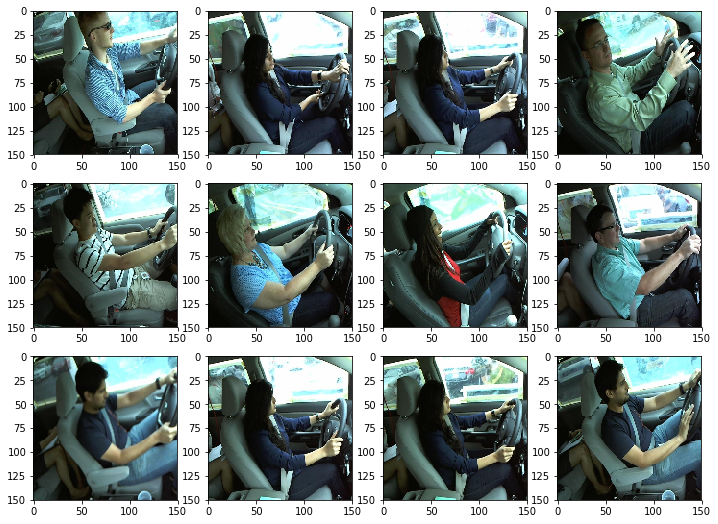

In [17]:
train_data, train_target, driver_id, unique_drivers = read_and_normalize_train_data(img_rows, img_cols, color_type_global)
test_data, test_id = read_and_normalize_test_data(img_rows, img_cols, color_type_global)
    
show_train_data(train_data, color_type_global)

histry = model.fit(train_data, train_target, batch_size = 64, epochs=nb_epoch, verbose=1, validation_split=0.2, shuffle=True)
    
test_prediction = model.predict(test_data)
    
info_string = 'r_' + str(img_rows) \
                    + '_c_' + str(img_cols) \
                    + '_ep_' + str(nb_epoch)
    
create_submission(test_prediction, test_id, info_string)